In [55]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import kurtosis
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf

#### Discrete Choice Approach

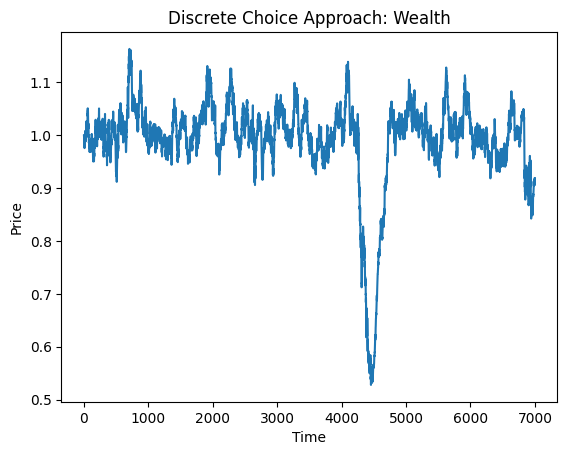

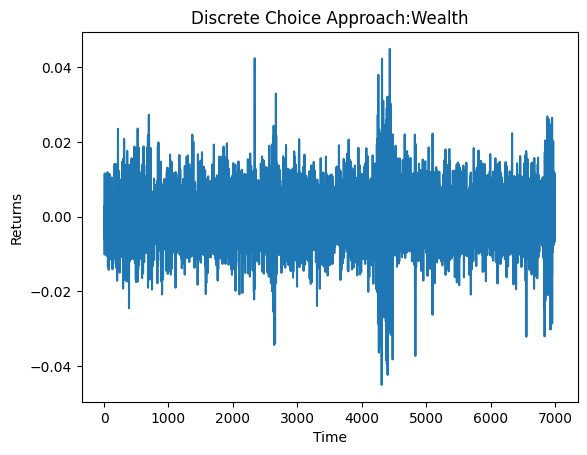

In [89]:
# Given Parameters
mu = 0.01
beta = 1

# Calibrated Paramters
# Note: Most parameters estimated by FW
phi = 1.00
chi = 1.20
eta = 0.991
alpha_w = 1580
alpha_O = 0
alpha_p = 0
sigma_f = 0.681
sigma_c = 1.724


# select run type
def switch(runType):
    global alpha_w
    global alpha_O
    global alpha_p
    global sigma_f
    global sigma_c
    if runType == 'W': #wealth only
        alpha_w = 1580
        alpha_O = 0
        alpha_p = 0
    elif runType == 'WP': # wealth and predisposition
        alpha_w = 2668
        alpha_O = 2.1
        alpha_p = 0
    elif runType == 'WM': # wealth misalignment
        # this case is not in the FW set: just testing the
        alpha_w = 1580
        alpha_O = 0
        alpha_p = 500
    elif runType == 'CN': # common noise
        mean_sig = (sigma_f + sigma_c)/2
        sigma_f = mean_sig
        sigma_c = mean_sig
        
runType = 'WP'
switch(runType)

T = 7000
P = np.zeros([T+1,1])
pstar = 0
Df = np.zeros([T,1])
Dc = np.zeros([T,1])
Nf = np.zeros([T,1])
Nc = np.zeros([T,1])
Gf = np.zeros([T,1])
Gc = np.zeros([T,1])
Wf = np.zeros([T,1])
Wc = np.zeros([T,1])
A = np.zeros([T,1])

# initial values(not given)
Nf[0:2] = 0.5
Nc[0:2] = 0.5

for t in range(2,T):
    
    #portfolio performance
    Gf[t] = ( np.exp(P[t]) - np.exp(P[t-1]) ) * Df[t-2]
    Gc[t] = ( np.exp(P[t]) - np.exp(P[t-1]) ) * Dc[t-2]
    
    #summarize performance over time
    Wf[t] = eta * Wf[t-1] + (1 - eta) * Gf[t]
    Wc[t] = eta * Wc[t-1] + (1 - eta) * Gc[t]
    
    # type fractions
    Nf[t] = 1 / ( 1 + np.exp(-beta * A[t-1]))
    Nc[t] = 1 - Nf[t]
    
    # The A[t] dynamic is set up to handle several models
    A[t] = alpha_w * ( Wf[t] - Wc[t]) + alpha_O + alpha_p * ( pstar - P[t])**2
    
    # demands
    Df[t] = phi * ( pstar - P[t] ) + sigma_f * np.random.randn(1)
    Dc[t] = chi * ( P[t] - P[t-1] ) + sigma_c * np.random.randn(1)
    
    # pricing
    P[t+1] = P[t] + mu * ( Nf[t] * Df[t] + Nc[t] * Dc[t] )

# returns
rr = P[1:T+1] - P[0:T]

# plot price
fig_p, ax_p = plt.subplots()
ax_p.plot(range(T), np.exp(P[1:]))
plt.xlabel('Time')
plt.ylabel('Price')
ax_p.set_title('Discrete Choice Approach: Wealth')
plt.show()

# plot returns
fig_r, ax_r = plt.subplots()
ax_r.plot(range(T), rr)
plt.xlabel('Time')
plt.ylabel('Returns')
ax_r.set_title('Discrete Choice Approach:Wealth')
plt.show()




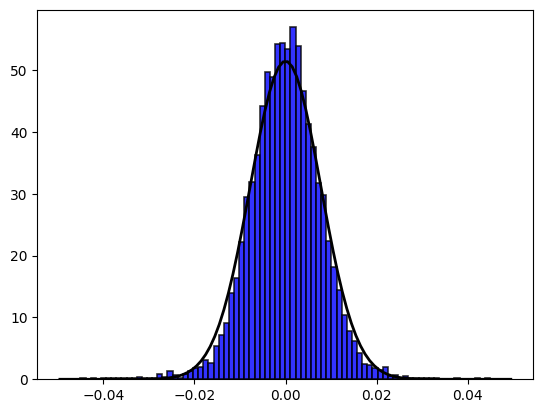

In [90]:
plt.hist(rr.flatten(),bins=80, density=True, alpha=0.8, color='b', edgecolor='black', linewidth=1.2)
# Fit a normal distribution to the data
mu, std = norm.fit(rr.flatten())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

# Plot normal distribution curve
plt.plot(x, p, 'k', linewidth=2)

In [92]:
# Calculate kurtosis (K value)
kurtosis_value = kurtosis(rr.flatten())
print(f"Sample kurtosis (K value): {kurtosis_value}")

Sample kurtosis (K value): 1.9112415495927095


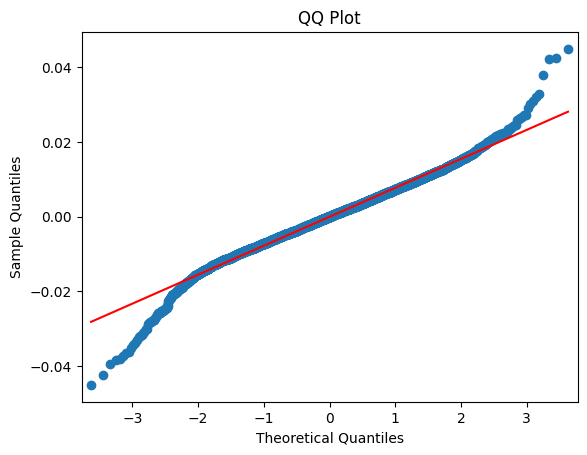

In [93]:

sm.qqplot(rr.flatten(), line='s')  # 's' line fit standardizes the data to have the same scale
plt.title('QQ Plot')
plt.show()

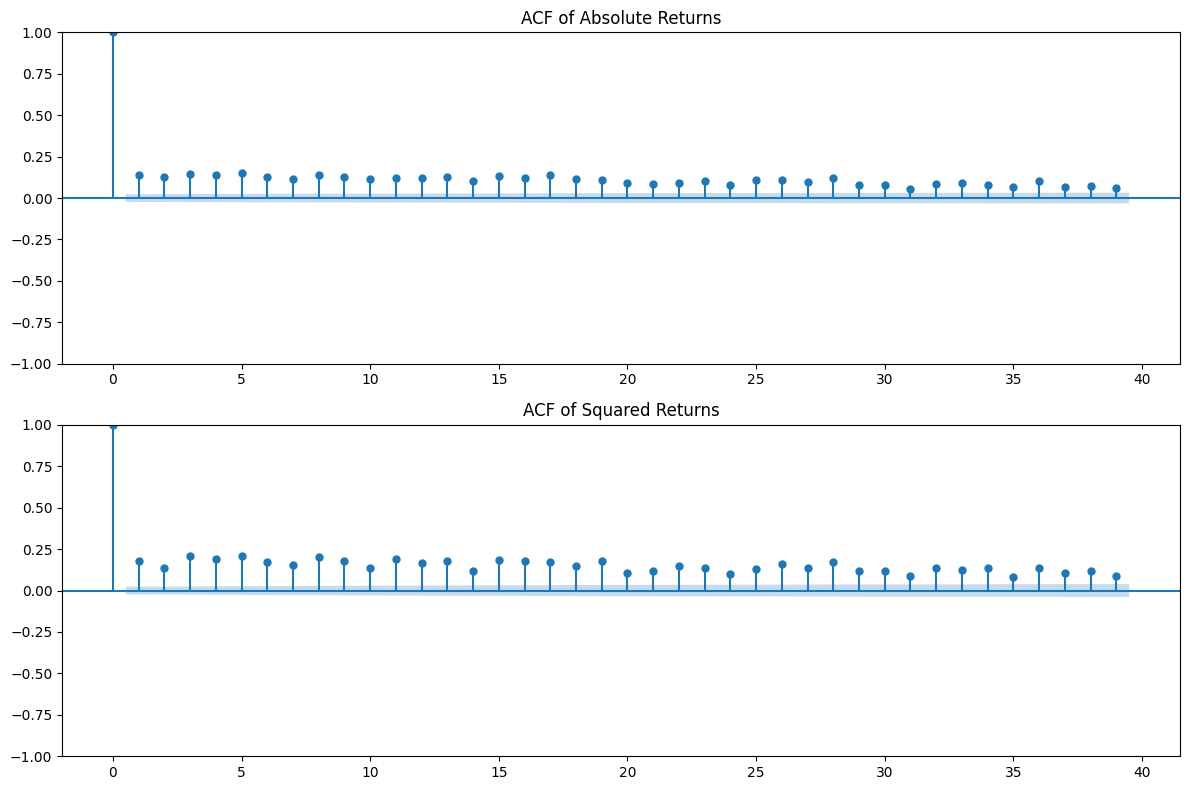

In [95]:
# Step 3: Autocorrelation Analysis
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(np.abs(rr.flatten()), ax=ax[0])
ax[0].set_title('ACF of Absolute Returns')
plot_acf(rr.flatten()**2, ax=ax[1])
ax[1].set_title('ACF of Squared Returns')
plt.tight_layout()
plt.show()

In [98]:
# ARCH Test For Volatility Clustering
arch_test = sm.stats.diagnostic.het_arch(rr.flatten())
print(f'ARCH Test p-value: {arch_test[1]}')

ARCH Test p-value: 9.57629673972567e-185


#### Transition Probability Approach

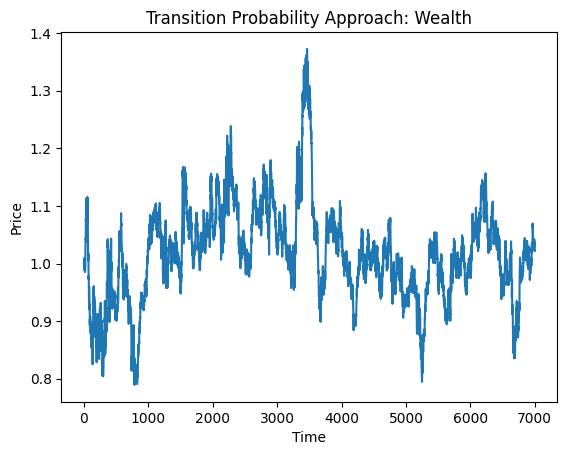

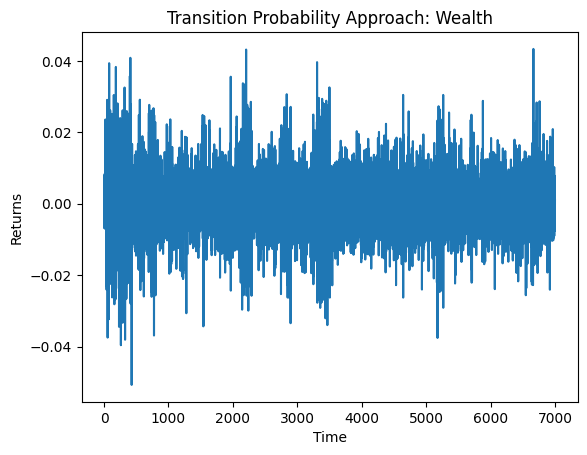

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Given Parameters
mu = 0.01
v = 0.05
# Calibrated Parameters
phi = 1.15
chi = 0.81
eta = 0.987
alpha_w = 1041
sigma_f = 0.715
sigma_c = 1.528

T = 7000
P = np.zeros([T+1,1])
pstar = 0
Df = np.zeros([T,1])
Dc = np.zeros([T,1])
Nf = np.zeros([T,1])
Nc = np.zeros([T,1])
Gf = np.zeros([T,1])
Gc = np.zeros([T,1])
Wf = np.zeros([T,1])
Wc = np.zeros([T,1])
A = np.zeros([T,1])
Pi_cf = np.zeros([T,1])
Pi_fc = np.zeros([T,1])

# Initial values (not given)
P[0:3] = 0
Df[0:3] = 0
Dc[0:3] = 0
Pi_cf[0:3] = 0.5
Pi_fc[0:3] = 0.5
Nf[0:3] = 0.5
Nc[0:3] = 0.5
Gf[0:3] = 0
Gc[0:3] = 0
Wf[0:3] = 0
Wc[0:3] = 0
A[0:3] = 0

for t in range(2, T):
    # performance
    Gf[t] = (np.exp(P[t]) - np.exp(P[t-1])) * Df[t-2]
    Gc[t] = (np.exp(P[t]) - np.exp(P[t-1])) * Dc[t-2]
    
    # summarize performance over time
    Wf[t] = eta * Wf[t-1] + (1 - eta) * Gf[t]
    Wc[t] = eta * Wc[t-1] + (1 - eta) * Gc[t]         
    
    # Determine transition probabilities
    Pi_cf[t] = min(1, v * np.exp(A[t-1]))
    Pi_fc[t] = min(1, v * np.exp(-A[t-1]))
    
    # TPA dynamics
    Nf[t] = Nf[t-1] + Nc[t-1] * Pi_cf[t] - Nf[t-1] * Pi_fc[t]
    Nc[t] = 1 - Nf[t]
    
    A[t] = alpha_w * (Wf[t] - Wc[t])
    
    # demands
    Df[t] = phi * (pstar - P[t]) + sigma_f * np.random.randn()
    Dc[t] = chi * (P[t] - P[t-1]) + sigma_c * np.random.randn()
    
    # pricing
    P[t+1] = P[t] + mu * (Nf[t] * Df[t] + Nc[t] * Dc[t])

# returns
rr = P[1:] - P[:-1]

# plot price
plt.figure()
plt.plot(np.exp(P))
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Transition Probability Approach: Wealth')

# plot returns
plt.figure()
plt.plot(rr)
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Transition Probability Approach: Wealth')

plt.show()


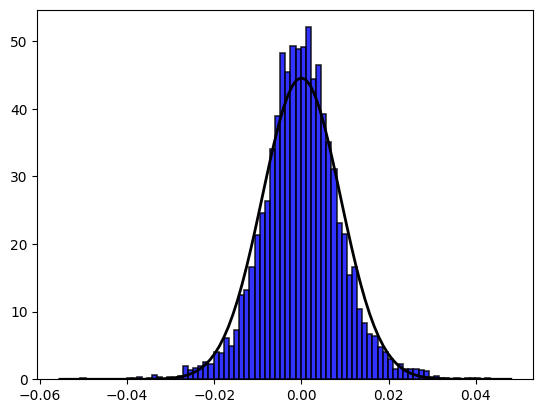

In [100]:
plt.hist(rr.flatten(),bins=80, density=True, alpha=0.8, color='b', edgecolor='black', linewidth=1.2)
# Fit a normal distribution to the data
mu, std = norm.fit(rr.flatten())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

# Plot normal distribution curve
plt.plot(x, p, 'k', linewidth=2)
plt.show()

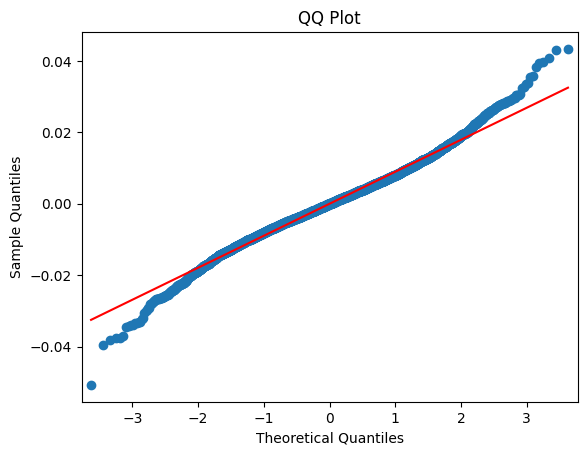

In [101]:
sm.qqplot(rr.flatten(), line='s')  # 's' line fit standardizes the data to have the same scale
plt.title('QQ Plot')
plt.show()

In [106]:
# Calculate kurtosis (K value)
kurtosis_value = kurtosis(rr.flatten())
print(f"Sample kurtosis (K value): {kurtosis_value}")

Sample kurtosis (K value): 1.4266862342404192


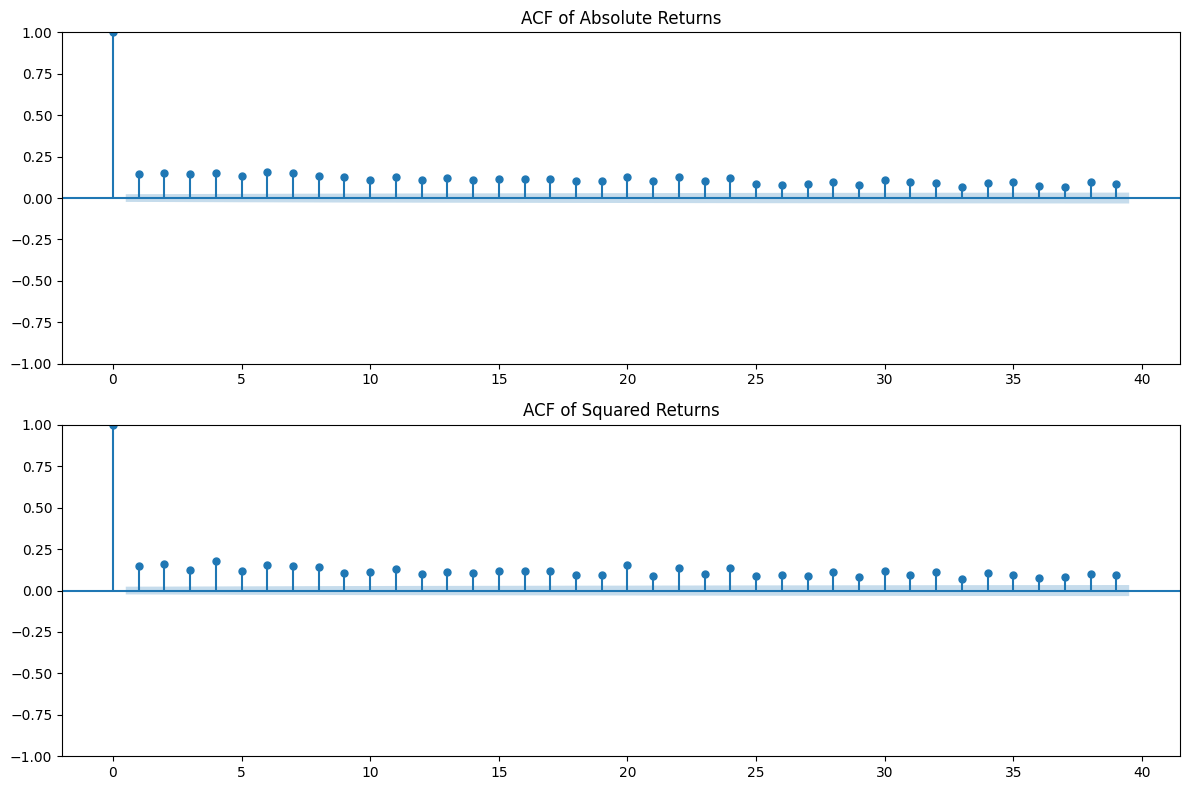

In [103]:
# Step 3: Autocorrelation Analysis
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(np.abs(rr.flatten()), ax=ax[0])
ax[0].set_title('ACF of Absolute Returns')
plot_acf(rr.flatten()**2, ax=ax[1])
ax[1].set_title('ACF of Squared Returns')
plt.tight_layout()
plt.show()

In [104]:
# ARCH Test For Volatility Clustering
arch_test = sm.stats.diagnostic.het_arch(rr.flatten())
print(f'ARCH Test p-value: {arch_test[1]}')

ARCH Test p-value: 5.012942428061442e-128
